In [76]:
# load and modify the data 
# from merge_data on!!! 

import matplotlib.pyplot as plt
import ast
import re
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

frames = []
calcs = []
threshold_gyro = 110
threshold_ps = 45
file_index = "0077"
index_avg = 18
bs_gyro = 100
bs_ps = 10
start = 100
dev_size = 3

file_name = f"../merge/merge_data/merge_data_{file_index}.txt"

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
fs = 12

def modify_data(data, expected_length=1):

    # convert to integer
    serial_data = ast.literal_eval(data)
    data = serial_data[100:len(serial_data)]

    return data

def determine_laser_gyro(acc_vec):
    laser_state = []

    # such that all minima are found
    for i in range(2):
        laser_state.append(1)

    for i in range(len(acc_vec)-4):
        temp = acc_vec[i:i+bs_gyro]

        # all values need to be inbetween |threshold|
        if all(-threshold_gyro < t < threshold_gyro for t in temp):
            laser_state.append(1)
        else:
            laser_state.append(0)

    for i in range(2):
        laser_state.append(1)

    return laser_state

def find_min_max_y(serial_data):
    y_max = []
    y_min = []

    max, _ = find_peaks(serial_data, prominence=5, distance=1000)
    min, _ = find_peaks(-np.array(serial_data), prominence = 5, distance=650)

    for i in range(len(max)):
        y_max.append(serial_data[max[i]])

    for i in range(len(min)):
        y_min.append(serial_data[min[i]])
    
    return min, max, y_min, y_max

def deviation(dev):
    dev_list = []
    for i in range(bs_ps-1):
        dev_list.append(0)

    for i in range(bs_ps, len(dev)+1): 
        temp = []
        for j in range(bs_ps):
            temp.append(dev[(i-bs_ps)+j])
        dev_list.append(temp)

    return dev_list

def determine_laser_state_dev_ps(dev_list):
    laser_state_dev = []
    for i in range(bs_ps-1):
        laser_state_dev.append(0)

    dev_list = dev_list[bs_ps-1:len(dev_list)]
    print(dev_list)
    for row in dev_list:

        if all(-(dev_size) <= value <= dev_size for value in row):
            laser_state_dev.append(1)
        else:
            laser_state_dev.append(0)

    return laser_state_dev

def determine_laser_state(laser_state_dev, average, threshold_ps):
    laser_state = []

    for i in range(len(average)):
        if ((average[i] < threshold_ps) and (laser_state_dev[i] == 1)):
            laser_state.append(1)
        else:   
            laser_state.append(0)

    return laser_state 

def compare_laser(laser_state_gyro, laser_state_pt):
    laser_comp = []
    for i in range(len(laser_state_gyro)):
        if laser_state_gyro[i] == laser_state_pt[i]:
            laser_comp.append(0)
        if (laser_state_gyro[i] == 1) & (laser_state_pt[i] == 0):
            laser_comp.append(1)        
        if (laser_state_gyro[i] == 0) & (laser_state_pt[i] == 1):
            laser_comp.append(-1)
    return laser_comp


with open(file_name, "r") as file:
    serial_data = file.read()

mod_data = modify_data(serial_data)
data_transposed = list(map(list, zip(*mod_data)))

### GYRO THINGS
# determine laser state
laser_state_gyro = determine_laser_gyro(data_transposed[0])
# calculate minima of laser 
minima_gyro, _ = find_peaks(-np.array(laser_state_gyro))

### PT THINGS
# Find min/max and the y-values (averages)
x_min, x_max, y_min, y_max = find_min_max_y(data_transposed[2])
min_pt = { 'index': [i for i in range(len(y_min))],
            'x_min': x_min,
            'y_min': y_min} 
max_pt = { 'index': [i for i in range(len(y_max))],
            'x_max': x_max,
            'y_max': y_max}
   
std_min_pt = np.std(list(y_min))
std_max_pt = np.std(list(y_max))

dev_list = deviation(data_transposed[3])
laser_state_dev = determine_laser_state_dev_ps(dev_list)          # dev übergeben
laser_state_pt = determine_laser_state(laser_state_dev, data_transposed[2], threshold_ps)     # avg übergeben

laser_comp = compare_laser(laser_state_gyro, laser_state_pt)


# [accX, ma_accX, dev_accX, accY, ... , dev_accZ, gyrX, ma_gyrX, dev_gyrX, gyrY, ... , dev_gyrZ, acc_vec, laser_state]
data_all = {'index': [i for i in range(len(data_transposed[0]))],
            'acc_vec':  data_transposed[0],
            'pt_raw': data_transposed[1],
            'pt_avg': data_transposed[2],
            'pt_dev': data_transposed[3],
            'reedf0': data_transposed[4],
            'reedf1': data_transposed[5],
            'reedb0': data_transposed[6],
            'reedb1': data_transposed[7],
            'laser_gyro': laser_state_gyro,
            'laser_pt': laser_state_pt,
            'laser_comp': laser_comp}

pd_all = pd.DataFrame(data = data_all)      
pd_min_pt = pd.DataFrame(data=min_pt)
pd_max_pt = pd.DataFrame(data=max_pt)             

frames.append([file_index, pd_all, minima_gyro, min_pt, max_pt, std_min_pt, std_max_pt])

print(pd_all.laser_gyro)


[[-4.0, -5.0, -6.0, -7.0, -7.0, -9.0, -11.0, -14.0, -16.0, -18.0], [-5.0, -6.0, -7.0, -7.0, -9.0, -11.0, -14.0, -16.0, -18.0, -21.0], [-6.0, -7.0, -7.0, -9.0, -11.0, -14.0, -16.0, -18.0, -21.0, -24.0], [-7.0, -7.0, -9.0, -11.0, -14.0, -16.0, -18.0, -21.0, -24.0, -28.0], [-7.0, -9.0, -11.0, -14.0, -16.0, -18.0, -21.0, -24.0, -28.0, -32.0], [-9.0, -11.0, -14.0, -16.0, -18.0, -21.0, -24.0, -28.0, -32.0, -35.0], [-11.0, -14.0, -16.0, -18.0, -21.0, -24.0, -28.0, -32.0, -35.0, -39.0], [-14.0, -16.0, -18.0, -21.0, -24.0, -28.0, -32.0, -35.0, -39.0, -42.0], [-16.0, -18.0, -21.0, -24.0, -28.0, -32.0, -35.0, -39.0, -42.0, -46.0], [-18.0, -21.0, -24.0, -28.0, -32.0, -35.0, -39.0, -42.0, -46.0, -50.0], [-21.0, -24.0, -28.0, -32.0, -35.0, -39.0, -42.0, -46.0, -50.0, -54.0], [-24.0, -28.0, -32.0, -35.0, -39.0, -42.0, -46.0, -50.0, -54.0, -58.0], [-28.0, -32.0, -35.0, -39.0, -42.0, -46.0, -50.0, -54.0, -58.0, -59.0], [-32.0, -35.0, -39.0, -42.0, -46.0, -50.0, -54.0, -58.0, -59.0, -62.0], [-35.0, -39.

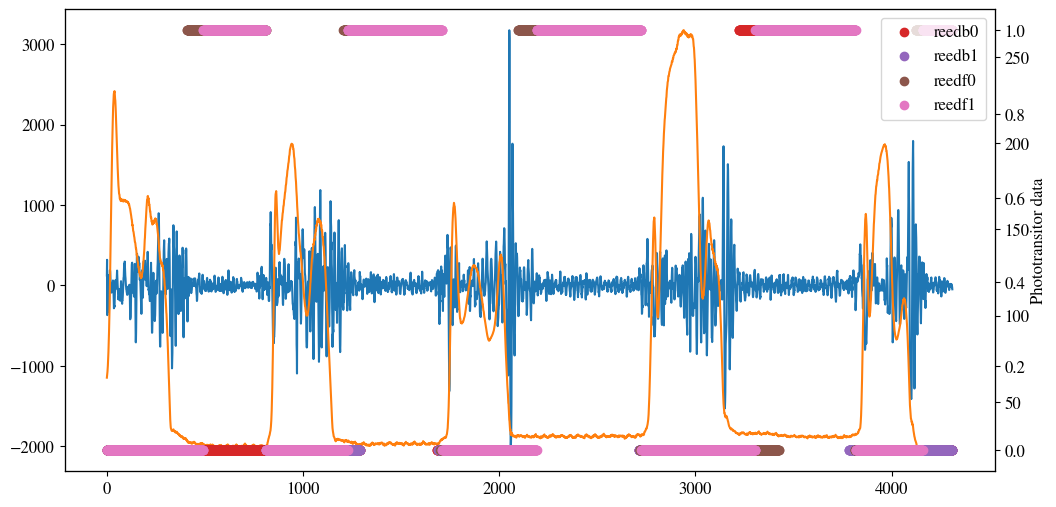

In [77]:
######## from 0012 on ##########

fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()
ax3 = ax.twinx()

#end = len(stage_data)
start = 100
end = len(data_transposed[0])
x = [i for i in range(end)]

plt.xlabel('Position')
plt.ylabel('Phototransitor data')

#plt.ylim(0,300)

ax.plot(pd_all.index, pd_all.acc_vec, color = 'C0', label = "phototransistor data [Intensity]")
ax2.plot(pd_all.index, pd_all.pt_avg, color = 'C1', label = 'stage position [mm]')
# ax2.scatter(pd_max_pt.x_max, pd_max_pt.y_max, color = 'C2', label = 'max')
# ax2.scatter(pd_min_pt.x_min, pd_min_pt.y_min, color = 'C3', label = 'min')

#ax3.scatter(pd_all.index, pd_all.laser_gyro, color = 'C2', label = 'laser_gyro')
ax3.scatter(pd_all.index, pd_all.reedb0, color = 'C3', label = 'reedb0')
ax3.scatter(pd_all.index, pd_all.reedb1, color = 'C4', label = 'reedb1')
ax3.scatter(pd_all.index, pd_all.reedf0, color = 'C5', label = 'reedf0')
ax3.scatter(pd_all.index, pd_all.reedf1, color = 'C6', label = 'reedf1')
# plt.plot(x[start:end], serial_data_all[3][start:end])
# plt.plot(x[start:end], serial_data_all[4][start:end])
plt.legend(loc="upper right")